## LSTM on whole trace

In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as scp

import pickle

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import time

import pickle as pkl
### 
import sys 
sys.path.append("..")
from utils import get_data
import os

### 
from utils_lstm import correlation, normalize, mse, comput_nr_params, get_sample

# get model
from model import LSTMModel

from training import train

In [2]:
"""
returns: (X_local, X_global, chirp, types, sampling_frequency, exp_time,
            local_m, local_sd, global_m, global_sd)
"""
X_local, X_global, chirp, types, sampling_frequency, *_  = get_data(
    normalize=True, data_dir='../data')

In [5]:
"""
one forward pass
"""
input_dim = 1
hidden_dim = 18
layer_dim = 1
output_dim = 28

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, readout='linear')

seq_dim = chirp.shape[0]
stimulus = torch.tensor(chirp, dtype=torch.float32)
stimulus = stimulus.view(-1, seq_dim, input_dim)#.to(device)

output = normalize(model.forward(stimulus)[0])

In [6]:
comput_nr_params(model), sum(p.numel() for p in model.parameters() if p.requires_grad)

(2044, 2044)

In [7]:
get_sample()

{'hash': 4316504,
 'lr': 0.15157723748306662,
 'max_steps': 40931,
 'decrease_lr_after': 39,
 'stop_after': 12,
 'seed': 7280214}

In [ ]:
"""
random search
"""
verbose = False

data = np.vstack([X_global,X_local])

for i in range(50):
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    config = get_sample()
    if verbose:
        print(config)
    
    torch.manual_seed(config['seed'])
    torch.cuda.manual_seed(config['seed'])
    np.random.seed(config['seed'])

    input_dim = 1
    hidden_dim = 18
    layer_dim = 1
    output_dim = 28

    model = LSTMModel(input_dim, 
                      hidden_dim, 
                      layer_dim, 
                      output_dim, readout='linear')

    """
    training
    """

    log_dir = os.getcwd()+'/results/glocal_v2/'+str(config['hash'])+'/'
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    
    # save config
    with open(log_dir+'config.pkl', 'wb') as f:
        pickle.dump(config, f)

    train(model, #lstm model
             data,
             chirp,
             loss_mode = 'corr', # in ['corr', 'mse']
             lr = config['lr'],
             decrease_lr_after=config['decrease_lr_after'], #10  # if loss went up x times, lower lr # corr: 20, mse:10
             stop_after= config['stop_after'],  # if lr was lowered x times, stop training # corr: 20, mse:10
             log_file = None,
            log_dir = log_dir,
             max_steps = config['max_steps'],
             verbose = verbose)
    
    print('finished run:',i)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


finished run: 0
finished run: 1
finished run: 2
finished run: 3
finished run: 4
finished run: 5
finished run: 6


In [21]:
"""
loading 
"""

model.load_state_dict(
                    torch.load(os.path.join(log_dir, 'model.pth')))


#with open(log_dir+'loss_tracking.pkl', "rb") as f:
#    loss_dict = pkl.load(f)

<All keys matched successfully>

In [6]:
best_loss = loss_dict['best_loss']
track_loss = loss_dict['track_loss']
track_lr_change = loss_dict[ 'track_lr_change']
track_lr = loss_dict[  'track_lr']
track_best_indeces = loss_dict[ 'track_best_indeces']
traces = loss_dict['traces']
runtime = loss_dict['runtime']

print('runtime', runtime)

runtime 17.411832571029663


In [27]:
seq_dim = chirp.shape[0]
stimulus = torch.tensor(chirp, dtype=torch.float32)
stimulus = stimulus.view(-1, seq_dim, input_dim).to('cuda:0')

traces = normalize(model.forward(stimulus)[0])

In [29]:
traces.shape

torch.Size([2048, 28])

In [31]:
data.shape

(28, 2048)

In [32]:
"""
get predictions and loss of fitted model
"""


y_pred = traces
#loss_pred = np.array(torch.mean((response.cpu().detach()-y_pred.cpu().detach())**2, dim=1))[0]
#-criterion(y_pred.cpu().detach(), response.cpu().detach())

# get correlation for each trace
y_pred_np = np.array(y_pred.cpu().detach()).T
corr_pred = np.zeros(28)
for i in range(28):
    corr_pred[i] = np.corrcoef(y_pred_np[i], data[i])[0,1]

print(corr_pred)
print(np.mean(corr_pred))


[0.97548071 0.96619548 0.98344547 0.96504529 0.95571721 0.94910366
 0.98360421 0.98420747 0.96310779 0.98240834 0.97856882 0.97125118
 0.97164534 0.94328197 0.97728011 0.97400526 0.98075782 0.97710587
 0.97661847 0.9616953  0.97615329 0.98595507 0.96632851 0.98534326
 0.97786123 0.97596916 0.98854253 0.98409849]
0.9735991895178583


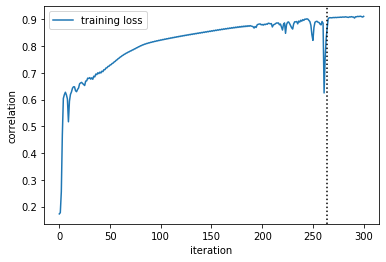

In [31]:
# good one: 0.019358109494508533
plt.plot(np.arange(len(track_loss)),
             -np.array(track_loss), label='training loss')

plt.xlabel('iteration')
plt.ylabel('correlation')
plt.legend()


for nr in track_lr_change:
    plt.axvline(nr, ls=':', c='black')
#plt.axhline(-0.79)

#plt.xlim(2000,3000)
#plt.ylim(0.944,0.9467)

NameError: name 'loss_pred' is not defined

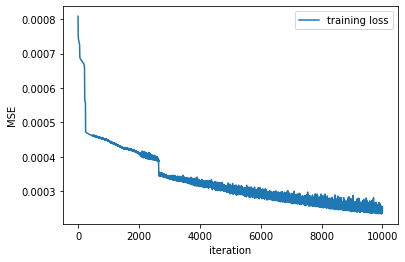

In [10]:
# good one: 0.019358109494508533
plt.plot(np.arange(len(track_loss)),
             track_loss, label='training loss')

plt.xlabel('iteration')
plt.ylabel('MSE')
plt.legend()

plt.plot(max_steps,-np.mean(loss_pred),'o',
         c='red')

In [118]:
"""
SKIP

linear transformation
"""
def scaling(x,a,b):
    return x*a + b

def scale_optimizing(y_pred, data):
    x0 = [5, np.mean(data)-np.mean(y_pred)]
    def min_fun(ab):
        a = ab[0]
        b = ab[1]
        y = scaling(y_pred, a, b)
        return mse(data,y)
    
    result = scp.optimize.minimize(min_fun, x0, method ='BFGS')
    
    y_scaled = scaling(y_pred, result.x[0], result.x[1])
    return y_scaled

y_scaled = np.zeros(np.shape(y_pred_np))

for i in range(14):
    y_scaled[i] = scale_optimizing(y_pred_np[i], X_global[i])

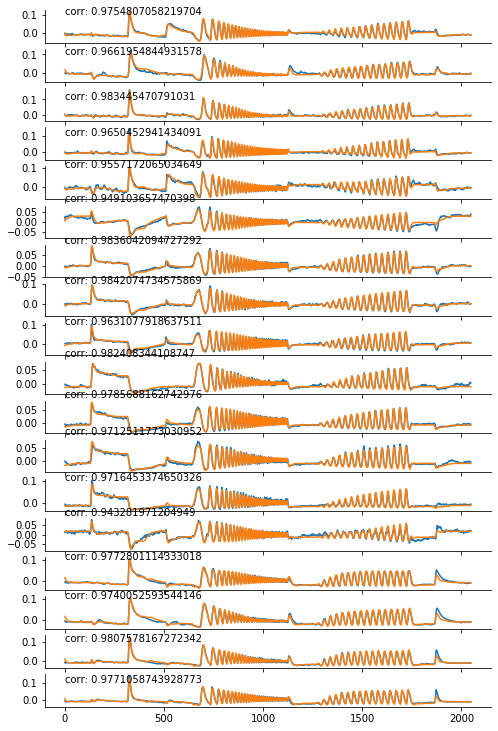

In [38]:
plt.figure(1, figsize = (8,20))
for cellindex in range(18):
    plt.subplot(28, 1, cellindex+1)
    plt.text(0,0.1,'corr: '+str(corr_pred[cellindex]))
    plt.plot(data[cellindex], label='data')
    plt.plot(y_pred_np[cellindex], label='model')    
sns.despine()
#plt.legend()

In [55]:
y_pred_np.shape

(14, 2048)

In [72]:
y_pred_np.shape

(14,)

In [69]:
np.mean(corr)

0.988789638307484

In [111]:
y_pred_cpu = y_pred.cpu().detach()[0]
response_cpu = response.cpu().detach()

In [125]:
# define stimulus
stimulus = torch.tensor(chirp, dtype=torch.float32)
stimulus = stimulus / torch.norm(stimulus, dim=0)


In [112]:
response_cpu.shape

torch.Size([2048, 14])

In [121]:
temp2 = y_pred_cpu - y_pred_cpu.mean(dim=0)
temp2 = temp2 / torch.norm(temp2, dim=0)

In [128]:
correlation(temp, temp2)

tensor(0.9888)